<a href="https://colab.research.google.com/github/ryyutku/DSGP/blob/anuk/Modelling/Model%205/Demand_forecast_model_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training model withoutdifferencing or any other augmentation and transformations**

In [274]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [275]:
df = pd.read_csv('CIEC Data.csv')

In [276]:
df.columns

Index(['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'GDP: Gross National Income', 'Government Debt',
       'New Vehicle Registrations', 'Vehicle Sales', 'Port Stay Duration',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Colombo port calls',
       'Tax income profits_gains', 'Tax on Export', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'Household_income',
       'Fuel_other_manufacture'],
      dtype='object')

In [277]:
df['date'] = pd.to_datetime(df['date'])

In [278]:
features = ['date','fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'GDP: Gross National Income', 'Government Debt',
       'New Vehicle Registrations', 'Vehicle Sales', 'Port Stay Duration',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Colombo port calls',
       'Tax income profits_gains', 'Tax on Export', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'Household_income',
       'Fuel_other_manufacture']

In [279]:
df_original = df.copy()

## **Checking the time frame with the most columns available**

In [280]:
def find_best_timeframe(df, time_column):
  df = df.copy()

  df_sorted = df.sort_values(by=time_column).set_index(time_column)

  # non-null values per row
  non_null_counts = df_sorted.notnull().sum(axis=1)

  # Finding the best periods with max non-null values
  best_start, best_end = None, None
  max_columns = 0

  current_start = df_sorted.index[0]
  current_max = non_null_counts.iloc[0]

  for i in range(1, len(non_null_counts)):
    if non_null_counts.iloc[i] >= max_columns:
      max_columns = non_null_counts.iloc[i]
      best_start = current_start
      best_end = df_sorted.index[i]
    else:
      current_start = df_sorted.index[i]

  return best_start, best_end

In [281]:
start,end = find_best_timeframe(df, 'date')
print(start, end)

2009-12-28 00:00:00 2014-12-29 00:00:00


In [282]:
df = df[(df['date']>=start) & (df['date']<=end)]

In [283]:
print(df.isnull().sum())

date                                          0
fuel_consumption                              0
petroleum_imports_crudeOil                    0
Taxes_on_Customs_and_Other_Import Duties      0
Foreign Direct Investments                    0
GDP Goods and Services                        1
GDP: Gross National Income                    1
Government Debt                             210
New Vehicle Registrations                     0
Vehicle Sales                                 0
Port Stay Duration                          262
Vehicle Sales Asia                            0
No.of Vessels Colombo                         0
Imports of Refined Products                   0
Colombo port calls                          262
Tax income profits_gains                      0
Tax on Export                               262
Tax Goods & Services                          0
Tax Road Transport                            0
GDP FCE Households                            1
Diesel User Price                       

In [284]:
drop_cols = ['Household_income','Fuel_other_manufacture','Tax on Export','Colombo port calls','Port Stay Duration','GDP: Gross National Income','Government Debt']

In [285]:
df = df.drop(columns=drop_cols)

In [286]:
len(df.columns)

21

# Modelling

In [287]:
df.dropna(inplace=True)

In [288]:
# Extracting date feature
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['quarter'] = df['date'].dt.quarter

df.drop('date',axis=1,inplace=True)

## **Scaling**

In [289]:
# Feature scaling
numerical_cols = df.select_dtypes(include=['float64','int64']).columns
numerical_cols = numerical_cols.drop('fuel_consumption')

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

fuel_scaler = StandardScaler()
df['fuel_consumption'] = fuel_scaler.fit_transform(df[['fuel_consumption']])

df.head()

,fuel_consumption,petroleum_imports_crudeOil,Taxes_on_Customs_and_Other_Import Duties,Foreign Direct Investments,GDP Goods and Services,New Vehicle Registrations,Vehicle Sales,Vehicle Sales Asia,No.of Vessels Colombo,Imports of Refined Products,...,Petrol User Price,Consumption_Oil,Sales 90 Octane,Sales 95 Octane,Sales Auto Diesel,year,month,day,weekday,quarter
1044,-1.507875,-1.468808,-1.213116,-1.509572,-1.838418,-1.381207,-1.578589,-1.109817,0.184838,-1.695141,...,-1.270956,-1.373789,-1.796721,-1.351332,0.634054,2010,1,4,0,1
1045,-1.507875,-1.468808,-1.213116,-1.509572,-1.838418,-1.381207,-1.578589,-1.109817,0.184838,-1.695141,...,-1.270956,-1.373789,-1.796721,-1.351332,0.634054,2010,1,11,0,1
1046,-1.507875,-1.468808,-1.213116,-1.509572,-1.838418,-1.381207,-1.578589,-1.109817,0.184838,-1.695141,...,-1.270956,-1.373789,-1.796721,-1.351332,0.634054,2010,1,18,0,1
1047,-1.507875,-1.468808,-1.213116,-1.509572,-1.838418,-1.381207,-1.578589,-1.109817,0.184838,-1.695141,...,-1.270956,-1.373789,-1.796721,-1.351332,0.634054,2010,1,25,0,1
1048,-1.507875,-1.468808,-1.213116,-1.509572,-1.838418,-0.747589,-1.578589,-1.109817,-1.084050,-1.695141,...,-1.270956,-1.373789,-1.796721,-1.351332,0.634054,2010,2,1,0,1


In [290]:
# splitting data into feature and target variables
X = df.drop('fuel_consumption',axis=1)
y = df['fuel_consumption']

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 42)
print("Training shape",X_train.shape)
print("Test df shape",X_test.shape)

Training shape (208, 24)
Test df shape (53, 24)


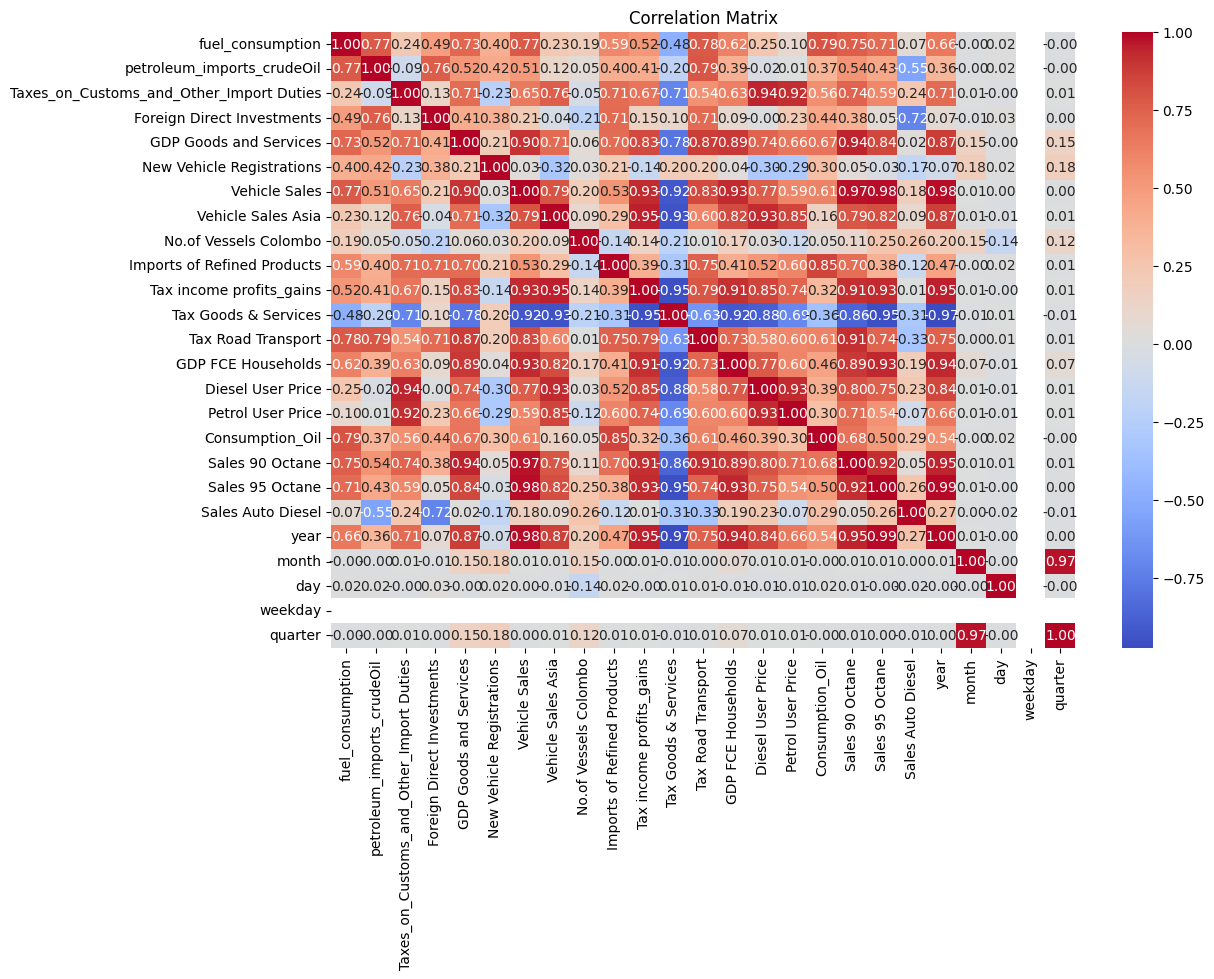

In [292]:
# visualize correlation matrix
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [293]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import plotly.express as px

In [294]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)


In [295]:
import plotly.graph_objects as go

# Using Random Forest (replace with y_pred_lr for Linear Regression)
predictions = y_pred_rf  # Replace with y_pred_lr if you're using Linear Regression

# Create traces for actual and predicted values
trace_actual = go.Scatter(
    x=y_test.index, y=y_test, mode='lines+markers', name='Actual Fuel Demand', line=dict(color='blue')
)

trace_predicted = go.Scatter(
    x=y_test.index, y=predictions, mode='lines+markers', name='Predicted Fuel Demand', line=dict(color='red', dash='dash')
)

# Create the layout for the plot
layout = go.Layout(
    title='Actual vs Predicted Fuel Demand (Test Set)',
    xaxis=dict(title='Index (Test Set)'),
    yaxis=dict(title='Fuel Demand'),
    showlegend=True
)

# Plot the figure
fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)
fig.show()


In [296]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Print out all the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


Mean Absolute Error (MAE): 0.0002961920523033788
Mean Squared Error (MSE): 4.649675787921121e-06
Root Mean Squared Error (RMSE): 0.002156310689098656
R-squared (R²): 0.9999948696284788


In [297]:
# Inverse transform on predicted and actual values
predicted_values = fuel_scaler.inverse_transform(predictions.reshape(-1, 1))
actual_values = fuel_scaler.inverse_transform(y_test.values.reshape(-1, 1))


In [298]:
# Using Random Forest (replace with y_pred_lr for Linear Regression)
predictions = predicted_values.flatten()  # Use inverse-transformed predictions
actuals = actual_values.flatten()  # Use inverse-transformed actual values

# Create traces for actual and predicted values
trace_actual = go.Scatter(
    x=y_test.index, y=actuals, mode='lines+markers', name='Actual Fuel Demand', line=dict(color='blue')
)

trace_predicted = go.Scatter(
    x=y_test.index, y=predictions, mode='lines+markers', name='Predicted Fuel Demand', line=dict(color='red', dash='dash')
)

# Create the layout for the plot
layout = go.Layout(
    title='Actual vs Predicted Fuel Demand (Test Set)',
    xaxis=dict(title='Date'),  # If you have datetime values, change x-axis title
    yaxis=dict(title='Fuel Demand (Original Scale)'),
    showlegend=True
)

# Plot the figure
fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)
fig.show()


In [299]:
print(y_test.index)

Index([1074, 1187, 1214, 1117, 1203, 1296, 1234, 1148, 1053, 1230, 1068, 1153,
       1140, 1249, 1283, 1180, 1121, 1050, 1252, 1224, 1089, 1164, 1063, 1104,
       1303, 1183, 1268, 1090, 1202, 1059, 1281, 1273, 1221, 1077, 1176, 1170,
       1217, 1054, 1158, 1141, 1157, 1257, 1069, 1265, 1211, 1062, 1128, 1184,
       1123, 1212, 1155, 1239, 1222],
      dtype='int64')


In [300]:
# Retrieve corresponding dates from the original dataset
y_test_dates = df_original.loc[y_test.index, 'date']  # Replace 'df_original' with the original dataframe before dropping 'date'

# Convert predictions and actual values back to original scale
predictions = predicted_values.flatten()  # Use inverse-transformed predictions
actuals = actual_values.flatten()  # Use inverse-transformed actual values

# Create traces for actual and predicted values
trace_actual = go.Scatter(
    x=y_test_dates, y=actuals, mode='lines+markers', name='Actual Fuel Demand', line=dict(color='blue')
)

trace_predicted = go.Scatter(
    x=y_test_dates, y=predictions, mode='lines+markers', name='Predicted Fuel Demand', line=dict(color='red', dash='dash')
)

# Create the layout for the plot
layout = go.Layout(
    title='Actual vs Predicted Fuel Demand (Test Set)',
    xaxis=dict(title='Date', tickformat="%Y-%m-%d"),  # Format dates properly
    yaxis=dict(title='Fuel Demand (Original Scale)'),
    showlegend=True
)

# Plot the figure
fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)
fig.show()


In [301]:
import plotly.express as px

# Create DataFrame for Plotly
plot_df = pd.DataFrame({'Date': y_test_dates, 'Actual': actuals, 'Predicted': predictions})

# Create the plot
fig = px.line(plot_df, x='Date', y=['Actual', 'Predicted'],
              labels={'value': 'Fuel Demand', 'variable': 'Legend'},
              title="Actual vs Predicted Fuel Demand (Test Set)")

# Customize the layout
fig.update_traces(mode="markers+lines")  # Show both lines & points
fig.update_layout(xaxis_title="Date", yaxis_title="Fuel Demand",
                  xaxis=dict(showgrid=False),  # Hide unnecessary grid lines
                  yaxis=dict(showgrid=True, zeroline=False),
                  legend_title_text="Legend")

fig.show()


In [306]:
import plotly.graph_objects as go

# Compute error (difference)
error = actuals - predictions

# Create figure
fig = go.Figure()

# Add actual values as a line plot
fig.add_trace(go.Scatter(
    x=y_test_dates, y=actuals, mode='lines+markers',
    name='Actual Fuel Demand', line=dict(color='blue')
))

# Add predicted values as a line plot
fig.add_trace(go.Scatter(
    x=y_test_dates, y=predictions, mode='lines+markers',
    name='Predicted Fuel Demand', line=dict(color='red', dash='dot')
))

# Add error bars (bar chart for differences)
fig.add_trace(go.Bar(
    x=y_test_dates, y=error, name='Prediction Error', marker=dict(color='orange'), opacity=0.5
))

# Update layout
fig.update_layout(title="Actual vs Predicted Fuel Demand with Error",
                  xaxis_title="Date", yaxis_title="Fuel Demand",
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=True, zeroline=False),
                  showlegend=True)

fig.show()


In [307]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add actual values as scatter plot (points only)
fig.add_trace(go.Scatter(
    x=y_test_dates, y=actuals, mode='markers',
    name='Actual Fuel Demand', marker=dict(color='blue', size=8, symbol='circle')
))

# Add predicted values as scatter plot (points only)
fig.add_trace(go.Scatter(
    x=y_test_dates, y=predictions, mode='markers',
    name='Predicted Fuel Demand', marker=dict(color='red', size=8, symbol='x')
))

# Update layout
fig.update_layout(title="Actual vs Predicted Fuel Demand (Test Set)",
                  xaxis_title="Date", yaxis_title="Fuel Demand",
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=True, zeroline=False),
                  showlegend=True)

fig.show()


## **Predicting future demand**

In [ ]:
import plotly.graph_objects as go

def predict_and_plot_future_demand(future_df, model, scaler, fuel_scaler):
    """
    Predict future fuel demand and plot the results.

    Parameters:
    - future_df: DataFrame containing future data (without the target variable)
    - model: Trained machine learning model
    - scaler: Scaler used for feature scaling (applied on training data)
    - fuel_scaler: Scaler used for scaling the 'fuel_consumption' values

    Returns:
    - future_df: DataFrame with predicted fuel demand
    """
    # Step 1: Prepare future data (Scaling the features)
    future_numerical_cols = future_df.select_dtypes(include=['float64', 'int64']).columns
    future_numerical_cols = future_numerical_cols.drop('fuel_consumption', errors='ignore')

    # Apply the same scaling transformation as the training data
    future_df[future_numerical_cols] = scaler.transform(future_df[future_numerical_cols])

    # Step 2: Make predictions on the future dataset
    future_predictions = model.predict(future_df)

    # Step 3: Inverse transform the predictions to get real-world fuel consumption values
    future_predictions = fuel_scaler.inverse_transform(future_predictions.reshape(-1, 1))

    # Add predictions to the future dataframe
    future_df['predicted_fuel_demand'] = future_predictions

    # Step 4: Plot the forecasted fuel demand using Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=future_df['date'],  # Ensure 'date' column exists in future_df
        y=future_df['predicted_fuel_demand'],
        mode='lines+markers',
        name='Forecasted Fuel Demand',
        line=dict(color='green', dash='dash')
    ))

    # Layout settings
    fig.update_layout(
        title='Forecasted Fuel Demand',
        xaxis_title='Date',
        yaxis_title='Fuel Demand',
        showlegend=True
    )

    # Show the plot
    fig.show()

    return future_df

# Example usage:
# future_df: Your dataframe with future data (includes date and feature columns)
# model: Trained model (e.g., Random Forest model)
# scaler: Feature scaler used in training
# fuel_scaler: Scaler used for 'fuel_consumption' (target variable)

# Call the method to predict and plot
future_predictions_df = predict_and_plot_future_demand(future_df, rf_model, scaler, fuel_scaler)
